In [4]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from molvs import standardize_smiles
from copy import deepcopy
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import permutation_test_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import joblib
import pickle
from numpy import savetxt
from padelpy import from_sdf
import shap
from tqdm.notebook import tqdm

In [5]:
def convert_smi_to_canon_smi(smi):

    try:
        canon_smi = Chem.MolToSmiles(Chem.MolFromSmiles(smi),isomericSmiles = False)
    except:
        canon_smi='wrong_smiles'
    return canon_smi

In [6]:
def standart(smi):
    global m
    if smi!='wrong_smiles':
        try:
            smiles=standardize_smiles(smi)
            m = Chem.MolFromSmiles(smi)
        except:
            smi='error kekule'
    else:
        m = 'check the smiles'
    return m

In [7]:
df_ws=pd.read_csv('rat_oral_LD50_WS.csv')
df_ws

,CAS_Number,SMILES,pLD50,"LD50,mg/kg"
0,626-48-2,Cc1cc(=O)[nH]c(=O)[nH]1,0.291207,64463.0000
1,27849-94-1,CC(CCc1ccc2c(c1)OCO2)NN,0.440660,75449.0000
2,110-54-3,CCCCCC,0.537460,24980.0000
3,1330-92-3,CCCCC(CC)COC(=O)C1=C(C(=O)OCC(CC)CCCC)CCCC1,0.539250,113917.0000
4,57-55-6,CC(O)CO,0.580330,19989.0000
...,...,...,...,...
7707,56073-10-0,O=c1oc2ccccc2c(O)c1C1CC(c2ccc(-c3ccc(Br)cc3)cc...,6.514700,0.1596
7708,130209-82-4,CC(C)OC(=O)CCC/C=C/CC1C(O)CC(O)C1CCC(O)CCc1ccccc1,6.937100,0.0500
7709,83805-11-2,C=C1/C(=C\C=C2/CCCC3(C)C2CCC3C(C)CCCC(O)(C(F)(...,7.099700,0.0417
7710,1746-01-6,Clc1cc2c(cc1Cl)Oc1cc(Cl)c(Cl)cc1O2,7.206800,0.0199


In [8]:
df_ws1 = deepcopy(df_ws)
df_ws1["SMILES"] = df_ws1.apply(lambda x: convert_smi_to_canon_smi(x.SMILES), axis=1)
df_ws1

,CAS_Number,SMILES,pLD50,"LD50,mg/kg"
0,626-48-2,Cc1cc(=O)[nH]c(=O)[nH]1,0.291207,64463.0000
1,27849-94-1,CC(CCc1ccc2c(c1)OCO2)NN,0.440660,75449.0000
2,110-54-3,CCCCCC,0.537460,24980.0000
3,1330-92-3,CCCCC(CC)COC(=O)C1=C(C(=O)OCC(CC)CCCC)CCCC1,0.539250,113917.0000
4,57-55-6,CC(O)CO,0.580330,19989.0000
...,...,...,...,...
7707,56073-10-0,O=c1oc2ccccc2c(O)c1C1CC(c2ccc(-c3ccc(Br)cc3)cc...,6.514700,0.1596
7708,130209-82-4,CC(C)OC(=O)CCCC=CCC1C(O)CC(O)C1CCC(O)CCc1ccccc1,6.937100,0.0500
7709,83805-11-2,C=C1C(=CC=C2CCCC3(C)C2CCC3C(C)CCCC(O)(C(F)(F)F...,7.099700,0.0417
7710,1746-01-6,Clc1cc2c(cc1Cl)Oc1cc(Cl)c(Cl)cc1O2,7.206800,0.0199


In [9]:
print('Original data: ', len(df_ws), 'molecules')
print('Failed data: ', len(df_ws1[df_ws1['SMILES']=='wrong_smiles']), 'molecules')

Original data:  7712 molecules
Failed data:  0 molecules


In [10]:
index=df_ws1.index[df_ws1['SMILES']=='wrong_smiles'].tolist()
wrong_smiles=df_ws.iloc[index]
wrong_smiles=wrong_smiles.SMILES
number=[x+1 for x in index]
bad_molecules = pd.DataFrame({'No. failed smiles in original set': number, 'SMILES of wrong structure: ': wrong_smiles}, index=None)
bad_molecules = bad_molecules.set_index('No. failed smiles in original set')
bad_molecules

,SMILES of wrong structure:
No. failed smiles in original set,


2.2  Standardization for work set

In [11]:
df_ws1["Molecule"] = df_ws1.apply(lambda x: standart(x.SMILES), axis=1)
moldf_ws=df_ws1[df_ws1['SMILES']!='wrong_smiles']
print('Kept data: ', len(moldf_ws), 'molecules')

Kept data:  7712 molecules


In [12]:
moldf_ws

,CAS_Number,SMILES,pLD50,"LD50,mg/kg",Molecule
0,626-48-2,Cc1cc(=O)[nH]c(=O)[nH]1,0.291207,64463.0000,<rdkit.Chem.rdchem.Mol object at 0x000002E8040...
1,27849-94-1,CC(CCc1ccc2c(c1)OCO2)NN,0.440660,75449.0000,<rdkit.Chem.rdchem.Mol object at 0x000002E8040...
2,110-54-3,CCCCCC,0.537460,24980.0000,<rdkit.Chem.rdchem.Mol object at 0x000002E8040...
3,1330-92-3,CCCCC(CC)COC(=O)C1=C(C(=O)OCC(CC)CCCC)CCCC1,0.539250,113917.0000,<rdkit.Chem.rdchem.Mol object at 0x000002E8040...
4,57-55-6,CC(O)CO,0.580330,19989.0000,<rdkit.Chem.rdchem.Mol object at 0x000002E8040...
...,...,...,...,...,...
7707,56073-10-0,O=c1oc2ccccc2c(O)c1C1CC(c2ccc(-c3ccc(Br)cc3)cc...,6.514700,0.1596,<rdkit.Chem.rdchem.Mol object at 0x000002E80A1...
7708,130209-82-4,CC(C)OC(=O)CCCC=CCC1C(O)CC(O)C1CCC(O)CCc1ccccc1,6.937100,0.0500,<rdkit.Chem.rdchem.Mol object at 0x000002E80A1...
7709,83805-11-2,C=C1C(=CC=C2CCCC3(C)C2CCC3C(C)CCCC(O)(C(F)(F)F...,7.099700,0.0417,<rdkit.Chem.rdchem.Mol object at 0x000002E80A1...
7710,1746-01-6,Clc1cc2c(cc1Cl)Oc1cc(Cl)c(Cl)cc1O2,7.206800,0.0199,<rdkit.Chem.rdchem.Mol object at 0x000002E80A1...


In [14]:
y_tr=moldf_ws.pLD50
y_tr

0       0.291207
1       0.440660
2       0.537460
3       0.539250
4       0.580330
          ...   
7707    6.514700
7708    6.937100
7709    7.099700
7710    7.206800
7711    7.602600
Name: pLD50, Length: 7712, dtype: float64

In [15]:
df = pd.DataFrame(moldf_ws, columns=["SMILES"])
df

,SMILES
0,Cc1cc(=O)[nH]c(=O)[nH]1
1,CC(CCc1ccc2c(c1)OCO2)NN
2,CCCCCC
3,CCCCC(CC)COC(=O)C1=C(C(=O)OCC(CC)CCCC)CCCC1
4,CC(O)CO
...,...
7707,O=c1oc2ccccc2c(O)c1C1CC(c2ccc(-c3ccc(Br)cc3)cc...
7708,CC(C)OC(=O)CCCC=CCC1C(O)CC(O)C1CCC(O)CCc1ccccc1
7709,C=C1C(=CC=C2CCCC3(C)C2CCC3C(C)CCCC(O)(C(F)(F)F...
7710,Clc1cc2c(cc1Cl)Oc1cc(Cl)c(Cl)cc1O2


In [16]:
df.to_csv('datasets/molecule_ws.smi', sep=',', index=False, header=False)

2.3  Load data and curation test set

In [17]:
df_ts=pd.read_csv('rat_oral_LD50_TS.csv')
df_ts

,CAS_Number,SMILES,pLD50,"LD50,mg/kg"
0,7782-40-3,C,0.017765,15388.8000
1,2842-38-8,OCCNC1CCCCC1,0.572840,38274.0000
2,66257-53-2,NC(=O)C(=O)O,0.624490,21133.0000
3,2173-56-0,CCCCCOC(=O)CCCC,0.686960,35395.0000
4,4726-93-6,O=C1CCCCC(=O)N1,0.750180,22586.0000
...,...,...,...,...
1924,3385-03-3,CC1(C)OC2CC3C4CC(F)C5=CC(=O)C=CC5(C)C4C(O)CC3(...,5.939000,0.4997
1925,2338-29-6,FC(F)(F)c1nc2c(Cl)c(Cl)c(Cl)c(Cl)c2[nH]1,6.121300,0.2435
1926,128606-48-4,CCOP(=S)(OCC)O/C(C)=C/C(=O)OC,6.282400,0.1399
1927,50585-41-6,Brc1cc2c(cc1Br)Oc1cc(Br)c(Br)cc1O2,6.698800,0.0992


In [18]:
df_ts1 = deepcopy(df_ts)
df_ts1["SMILES"] = df_ts1.apply(lambda x: convert_smi_to_canon_smi(x.SMILES), axis=1)
df_ts1

,CAS_Number,SMILES,pLD50,"LD50,mg/kg"
0,7782-40-3,C,0.017765,15388.8000
1,2842-38-8,OCCNC1CCCCC1,0.572840,38274.0000
2,66257-53-2,NC(=O)C(=O)O,0.624490,21133.0000
3,2173-56-0,CCCCCOC(=O)CCCC,0.686960,35395.0000
4,4726-93-6,O=C1CCCCC(=O)N1,0.750180,22586.0000
...,...,...,...,...
1924,3385-03-3,CC1(C)OC2CC3C4CC(F)C5=CC(=O)C=CC5(C)C4C(O)CC3(...,5.939000,0.4997
1925,2338-29-6,FC(F)(F)c1nc2c(Cl)c(Cl)c(Cl)c(Cl)c2[nH]1,6.121300,0.2435
1926,128606-48-4,CCOP(=S)(OCC)OC(C)=CC(=O)OC,6.282400,0.1399
1927,50585-41-6,Brc1cc2c(cc1Br)Oc1cc(Br)c(Br)cc1O2,6.698800,0.0992


In [19]:
print('Original data: ', len(df_ts), 'molecules')
print('Failed data: ', len(df_ts1[df_ts1['SMILES']=='wrong_smiles']), 'molecules')

Original data:  1929 molecules
Failed data:  0 molecules


In [20]:
index=df_ts1.index[df_ts1['SMILES']=='wrong_smiles'].tolist()
wrong_smiles=df_ts.iloc[index]
wrong_smiles=wrong_smiles.SMILES
number=[x+1 for x in index]
bad_molecules = pd.DataFrame({'No. failed smiles in original set': number, 'SMILES of wrong structure: ': wrong_smiles}, index=None)
bad_molecules = bad_molecules.set_index('No. failed smiles in original set')
bad_molecules

,SMILES of wrong structure:
No. failed smiles in original set,


2.4  Standardization for test set

In [21]:
df_ts1["Molecule"] = df_ts1.apply(lambda x: standart(x.SMILES), axis=1)
moldf_ts=df_ts1[df_ts1['SMILES']!='wrong_smiles']
print('Kept data: ', len(moldf_ts), 'molecules')

Kept data:  1929 molecules


In [22]:
moldf_ts

,CAS_Number,SMILES,pLD50,"LD50,mg/kg",Molecule
0,7782-40-3,C,0.017765,15388.8000,<rdkit.Chem.rdchem.Mol object at 0x000002E803F...
1,2842-38-8,OCCNC1CCCCC1,0.572840,38274.0000,<rdkit.Chem.rdchem.Mol object at 0x000002E803F...
2,66257-53-2,NC(=O)C(=O)O,0.624490,21133.0000,<rdkit.Chem.rdchem.Mol object at 0x000002E803F...
3,2173-56-0,CCCCCOC(=O)CCCC,0.686960,35395.0000,<rdkit.Chem.rdchem.Mol object at 0x000002E803F...
4,4726-93-6,O=C1CCCCC(=O)N1,0.750180,22586.0000,<rdkit.Chem.rdchem.Mol object at 0x000002E803F...
...,...,...,...,...,...
1924,3385-03-3,CC1(C)OC2CC3C4CC(F)C5=CC(=O)C=CC5(C)C4C(O)CC3(...,5.939000,0.4997,<rdkit.Chem.rdchem.Mol object at 0x000002E80A1...
1925,2338-29-6,FC(F)(F)c1nc2c(Cl)c(Cl)c(Cl)c(Cl)c2[nH]1,6.121300,0.2435,<rdkit.Chem.rdchem.Mol object at 0x000002E80A1...
1926,128606-48-4,CCOP(=S)(OCC)OC(C)=CC(=O)OC,6.282400,0.1399,<rdkit.Chem.rdchem.Mol object at 0x000002E80A1...
1927,50585-41-6,Brc1cc2c(cc1Br)Oc1cc(Br)c(Br)cc1O2,6.698800,0.0992,<rdkit.Chem.rdchem.Mol object at 0x000002E80A1...


In [23]:
y_ts=moldf_ts.pLD50
y_ts

0       0.017765
1       0.572840
2       0.624490
3       0.686960
4       0.750180
          ...   
1924    5.939000
1925    6.121300
1926    6.282400
1927    6.698800
1928    9.541100
Name: pLD50, Length: 1929, dtype: float64

In [24]:
df = pd.DataFrame(moldf_ts, columns=["SMILES"])
df.to_csv('datasets/molecule_ts.smi', sep=',', index=False, header=False)

Descriptor calculation for work set

In [26]:
import glob
xml_files = glob.glob("fingerprints_xml/*.xml")
xml_files.sort()
xml_files

['fingerprints_xml\\AtomPairs2DFingerprintCount.xml',
 'fingerprints_xml\\AtomPairs2DFingerprinter.xml',
 'fingerprints_xml\\EStateFingerprinter.xml',
 'fingerprints_xml\\ExtendedFingerprinter.xml',
 'fingerprints_xml\\Fingerprinter.xml',
 'fingerprints_xml\\GraphOnlyFingerprinter.xml',
 'fingerprints_xml\\KlekotaRothFingerprintCount.xml',
 'fingerprints_xml\\KlekotaRothFingerprinter.xml',
 'fingerprints_xml\\MACCSFingerprinter.xml',
 'fingerprints_xml\\PubchemFingerprinter.xml',
 'fingerprints_xml\\SubstructureFingerprintCount.xml',
 'fingerprints_xml\\SubstructureFingerprinter.xml']

In [27]:
FP_list = ['AtomPairs2DCount',
 'AtomPairs2D',
 'EState',
 'CDKextended',
 'CDK',
 'CDKgraphonly',
 'KlekotaRothCount',
 'KlekotaRoth',
 'MACCS',
 'PubChem',
 'SubstructureCount',
 'Substructure']

In [28]:
fp = dict(zip(FP_list, xml_files))
fp

{'AtomPairs2DCount': 'fingerprints_xml\\AtomPairs2DFingerprintCount.xml',
 'AtomPairs2D': 'fingerprints_xml\\AtomPairs2DFingerprinter.xml',
 'EState': 'fingerprints_xml\\EStateFingerprinter.xml',
 'CDKextended': 'fingerprints_xml\\ExtendedFingerprinter.xml',
 'CDK': 'fingerprints_xml\\Fingerprinter.xml',
 'CDKgraphonly': 'fingerprints_xml\\GraphOnlyFingerprinter.xml',
 'KlekotaRothCount': 'fingerprints_xml\\KlekotaRothFingerprintCount.xml',
 'KlekotaRoth': 'fingerprints_xml\\KlekotaRothFingerprinter.xml',
 'MACCS': 'fingerprints_xml\\MACCSFingerprinter.xml',
 'PubChem': 'fingerprints_xml\\PubchemFingerprinter.xml',
 'SubstructureCount': 'fingerprints_xml\\SubstructureFingerprintCount.xml',
 'Substructure': 'fingerprints_xml\\SubstructureFingerprinter.xml'}

In [ ]:
from padelpy import padeldescriptor

fingerprint = 'AtomPairs2D'

fingerprint_output_file = ''.join([fingerprint,'.csv'])
fingerprint_descriptortypes = fp[fingerprint]

padeldescriptor(mol_dir='datasets/molecule_ws.smi',
                d_file=fingerprint_output_file,
                descriptortypes= fingerprint_descriptortypes,
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                threads=2,
                removesalt=True,
                log=True,
                fingerprints=True)

In [29]:
descriptors_AtomPairs2D = pd.read_csv('AtomPairs2D.csv')

In [30]:
descriptors_AtomPairs2D

,Name,AD2D1,AD2D2,AD2D3,AD2D4,AD2D5,AD2D6,AD2D7,AD2D8,AD2D9,...,AD2D771,AD2D772,AD2D773,AD2D774,AD2D775,AD2D776,AD2D777,AD2D778,AD2D779,AD2D780
0,AUTOGEN_molecule_ws_1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AUTOGEN_molecule_ws_2,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AUTOGEN_molecule_ws_3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AUTOGEN_molecule_ws_4,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AUTOGEN_molecule_ws_5,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,AUTOGEN_molecule_ws_7708,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7708,AUTOGEN_molecule_ws_7709,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7709,AUTOGEN_molecule_ws_7710,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7710,AUTOGEN_molecule_ws_7711,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
x_tr_AtomPairs2D = descriptors_AtomPairs2D.drop('Name', axis=1)

In [32]:
x_tr_AtomPairs2D = np.array(x_tr_AtomPairs2D, dtype=np.float32)
y_tr = np.array(y_tr, dtype=np.float32)

In [33]:
savetxt('models/Padels/x_tr_AtomPairs2D.csv', x_tr_AtomPairs2D, delimiter=',')

## Descriptor calculation for test set

In [ ]:
from padelpy import padeldescriptor

fingerprint = 'AtomPairs2D'

fingerprint_output_file = ''.join([fingerprint,'_ts.csv']) #PubChem.csv
fingerprint_descriptortypes = fp[fingerprint]

padeldescriptor(mol_dir='molecule_ts.smi',
                d_file=fingerprint_output_file, #'PubChem.csv'
                #descriptortypes='PubChem.xml',
                descriptortypes= fingerprint_descriptortypes,
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                threads=2,
                removesalt=True,
                log=False,
                fingerprints=True)

In [34]:
descriptors_AtomPairs2D_ts = pd.read_csv('AtomPairs2D_ts.csv')

In [35]:
x_ts = descriptors_AtomPairs2D_ts.drop('Name', axis=1)
x_ts

,AD2D1,AD2D2,AD2D3,AD2D4,AD2D5,AD2D6,AD2D7,AD2D8,AD2D9,AD2D10,...,AD2D771,AD2D772,AD2D773,AD2D774,AD2D775,AD2D776,AD2D777,AD2D778,AD2D779,AD2D780
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1925,1,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1926,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1927,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
x_ts.shape

(1929, 780)

# GradientBoostingRegressor model building and validation

In [38]:
seed = 42
cv=KFold(n_splits=5, random_state=seed, shuffle=True)
param_grid = {'learning_rate': [0.02,0.05],
                  'subsample'    : [0.9, 0.5,  0.1],
                  'n_estimators' : [100,500,1000],
                  'max_depth'    : [4,10]
                 }

In [39]:
m = GridSearchCV(GradientBoostingRegressor(), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [40]:
m.fit(x_tr_AtomPairs2D, y_tr)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.02, 0.05], 'max_depth': [4, 10],
                         'n_estimators': [100, 500, 1000],
                         'subsample': [0.9, 0.5, 0.1]},
             verbose=1)

In [41]:
best_GBR = m.best_estimator_

In [42]:
m.best_params_

{'learning_rate': 0.02, 'max_depth': 10, 'n_estimators': 500, 'subsample': 0.5}

In [43]:
y_pred_ws_GBR = best_GBR.predict(x_tr_AtomPairs2D)

In [44]:
R2_WS = round(r2_score(y_tr, y_pred_ws_GBR), 2)
R2_WS

0.82

In [45]:
RMSE_WS=round(np.sqrt(mean_absolute_error(y_tr, y_pred_ws_GBR)), 2)
RMSE_WS

0.52

In [46]:
y_pred_CV_GBR = cross_val_predict(best_GBR, x_tr_AtomPairs2D, y_tr, cv=cv)

In [47]:
y_pred_CV_GBR

array([1.64254648, 2.60640211, 1.62211477, ..., 3.81940267, 3.06300013,
       2.79687056])

In [48]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.49

In [49]:
RMSE_CV=round(np.sqrt(mean_absolute_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.68

# Prediction for test set's molecules

In [50]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [51]:
y_pred_GBR = best_GBR.predict(x_ts)

In [52]:
Q2_TS = round(r2_score(y_ts, y_pred_GBR), 2)
Q2_TS

0.49

In [53]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts, y_pred_GBR)), 2)
RMSE_TS

0.68

## save the model to disk

In [54]:
pickle.dump(best_GBR, open('models/Padels/GBR_AtomPairs2D.pkl', 'wb'))

load the model from disk

In [55]:
best_GBR = pickle.load(open('models/Padels/GBR_AtomPairs2D.pkl', 'rb'))

## Y-randomization GradientBoostingRegressor model

In [56]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_GBR, x_tr_AtomPairs2D, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=seed)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 57.6min


True score =  0.49 
Y-randomization =  -0.14 
p-value =  0.0196


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 92.6min finished


## Estimating applicability domain. Method - Euclidian distances, K=1

In [57]:
x_tr=x_tr_AtomPairs2D

In [58]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [59]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,7702,7703,7704,7705,7706,7707,7708,7709,7710,7711
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.000000,2.449490,0.000000,0.000000,0.000000,0.000000,2.645751,0.000000,0.000000,1.000000,...,1.732051,2.236068,2.000000,3.316625,1.000000,1.732051,0.000000,3.316625,2.828427,1.732051
2,1.000000,2.449490,0.000000,0.000000,0.000000,0.000000,2.645751,0.000000,0.000000,1.000000,...,2.449490,2.449490,2.236068,3.464102,2.645751,1.732051,0.000000,3.316625,3.316625,2.000000
3,1.414214,2.449490,0.000000,0.000000,1.000000,1.732051,2.645751,0.000000,0.000000,2.645751,...,2.449490,3.000000,2.449490,3.605551,3.000000,2.000000,1.414214,3.464102,3.741657,2.236068
4,1.732051,2.645751,0.000000,0.000000,1.000000,1.732051,2.828427,0.000000,0.000000,2.828427,...,2.645751,3.162278,2.449490,3.741657,3.162278,2.000000,1.414214,3.464102,3.741657,2.236068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,10.246951,9.848858,10.677078,10.049875,10.723805,10.392304,10.198039,10.000000,10.049875,10.954452,...,10.535654,10.344080,10.049875,9.797959,10.440307,10.049875,10.148891,9.746795,10.198039,9.899495
7708,10.440307,9.899495,10.723805,10.198039,10.770329,10.440307,10.535654,10.148891,10.099504,11.000000,...,10.583005,10.677078,10.049875,9.848858,10.677078,10.295630,10.344080,9.848858,10.198039,10.000000
7709,10.862781,10.344080,10.862781,10.630146,11.000000,10.816654,10.630146,10.583005,10.535654,11.135529,...,10.954452,10.770329,10.630146,9.899495,10.862781,10.723805,10.770329,10.049875,10.862781,10.630146
7710,11.135529,10.535654,11.224972,10.677078,11.357817,11.045361,10.816654,10.770329,10.630146,11.313708,...,11.313708,10.954452,10.677078,9.899495,11.135529,10.770329,10.862781,10.049875,11.224972,10.630146


In [60]:
similarity= neighbors_k

In [61]:
Dmean=np.mean(similarity[1,:])

In [62]:
round(Dmean, 2)

1.36

In [63]:
std=np.std(similarity[1,:])

In [64]:
round(std, 2)

1.35

In [65]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

2.03


In [66]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [67]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928
0,1.000000,0.000000,1.732051,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,3.464102,2.449490,2.449490,0.000000,2.236068,0.000000,1.732051,3.741657,1.000000
1,1.000000,0.000000,2.000000,0.000000,1.414214,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,4.358899,3.162278,2.645751,1.414214,2.449490,1.732051,2.645751,3.872983,1.000000
2,1.000000,0.000000,2.000000,0.000000,1.414214,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,4.582576,3.316625,2.645751,1.414214,2.828427,2.449490,3.000000,4.242640,1.000000
3,1.414214,0.000000,2.236068,0.000000,1.414214,1.000000,0.000000,1.000000,1.000000,0.000000,...,1.000000,4.582576,3.605551,2.828427,1.732051,3.000000,2.449490,3.000000,4.358899,1.000000
4,1.414214,1.000000,2.236068,0.000000,1.414214,1.000000,0.000000,1.000000,1.000000,0.000000,...,1.000000,4.582576,3.605551,3.000000,2.236068,3.162278,2.449490,3.000000,4.472136,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,10.908712,10.148891,10.630146,10.148891,10.392304,10.440307,10.099504,10.770329,10.630146,10.099504,...,10.148891,10.000000,11.269427,10.000000,10.770329,9.848858,10.954452,10.488089,10.862781,10.295630
7708,10.954452,10.198039,10.770329,10.198039,10.488089,10.488089,10.148891,10.816654,10.770329,10.148891,...,10.246951,10.099504,11.313708,10.295630,10.816654,9.848858,10.954452,10.816654,10.862781,10.392304
7709,11.090536,10.583005,11.045361,10.630146,10.816654,10.723805,10.535654,10.954452,11.000000,10.583005,...,10.770329,10.148891,11.313708,10.488089,11.045361,9.949874,11.000000,10.908712,10.862781,10.908712
7710,11.445523,10.862781,11.313708,10.723805,11.090536,11.090536,10.723805,11.313708,11.357817,10.677078,...,10.862781,10.198039,11.357817,10.535654,11.090536,10.000000,11.045361,11.090536,11.224972,10.954452


In [68]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[1.    0.    1.732 ... 1.732 3.742 1.   ]


In [69]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True  True  True ...  True False  True]


In [70]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.73


In [71]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [   0    1    2 ... 1925 1926 1928]


In [72]:
out_Ad=list(np.where(cpd_AD == 0)[0])

## Prediction only for molecules included in AD

In [73]:
y_pred_GBR_ad=list(y_pred_GBR)

In [74]:
y_pred_GBR_ad[:] = [x for i,x in enumerate(y_pred_GBR_ad) if i not in out_Ad]

In [75]:
len(y_pred_GBR_ad)

1400

In [76]:
y_ts_ad=list(y_ts)

In [77]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [78]:
len(y_ts_ad)

1400

In [79]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_GBR_ad), 2)
Q2_TS

0.53

In [80]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts_ad, y_pred_GBR_ad)), 2)
RMSE_TS

0.65

# SVM model building and validation

In [81]:
param_grid = {"C": [10 ** i for i in range(0, 5)],
              "gamma": [10 ** i for i in range(-6, 0)]}

In [82]:
seed = 42
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [83]:
svm = GridSearchCV(SVR(C=1.0, epsilon=0.2), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [84]:
svm.fit(x_tr, y_tr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVR(epsilon=0.2), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000, 10000],
                         'gamma': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]},
             verbose=1)

In [85]:
svm.best_params_
best_svm = svm.best_estimator_

In [86]:
svm.best_params_

{'C': 1, 'gamma': 0.1}

In [87]:
y_pred_ws_svm = best_svm.predict(x_tr)

In [88]:
R2_WS = round(r2_score(y_tr, y_pred_ws_svm), 2)
R2_WS

0.71

In [89]:
RMSE_WS=round(np.sqrt(mean_absolute_error(y_tr, y_pred_ws_svm)), 2)
RMSE_WS

0.57

In [90]:
y_pred_CV_svm = cross_val_predict(best_svm, x_tr, y_tr, cv=cv)

In [91]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_svm), 2)
Q2_CV

0.46

In [92]:
RMSE_CV=round(np.sqrt(mean_absolute_error(y_tr, y_pred_CV_svm)), 2)
RMSE_CV

0.69

# 9. Prediction for test set's molecules

In [93]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [94]:
y_pred_svm = best_svm.predict(x_ts)

In [95]:
Q2_TS = round(r2_score(y_ts, y_pred_svm), 2)
Q2_TS

0.48

In [96]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts, y_pred_svm)), 2)
RMSE_TS

0.69

save the model to disk

In [97]:
pickle.dump(best_svm, open('models/Padels/Toxicity_SVM_AtomPairs2D.pkl', 'wb'))

load the model from disk

In [98]:
best_svm = pickle.load(open('models/Padels/Toxicity_SVM_AtomPairs2D.pkl', 'rb'))

# 10. Y-randomization SVM model

In [99]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_svm, x_tr, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=seed)
print('True score = ', score.round(3),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 29.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 46.6min finished


True score =  0.459 
Y-randomization =  -0.09 
p-value =  0.0196


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [100]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [101]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,7702,7703,7704,7705,7706,7707,7708,7709,7710,7711
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.000000,2.449490,0.000000,0.000000,0.000000,0.000000,2.645751,0.000000,0.000000,1.000000,...,1.732051,2.236068,2.000000,3.316625,1.000000,1.732051,0.000000,3.316625,2.828427,1.732051
2,1.000000,2.449490,0.000000,0.000000,0.000000,0.000000,2.645751,0.000000,0.000000,1.000000,...,2.449490,2.449490,2.236068,3.464102,2.645751,1.732051,0.000000,3.316625,3.316625,2.000000
3,1.414214,2.449490,0.000000,0.000000,1.000000,1.732051,2.645751,0.000000,0.000000,2.645751,...,2.449490,3.000000,2.449490,3.605551,3.000000,2.000000,1.414214,3.464102,3.741657,2.236068
4,1.732051,2.645751,0.000000,0.000000,1.000000,1.732051,2.828427,0.000000,0.000000,2.828427,...,2.645751,3.162278,2.449490,3.741657,3.162278,2.000000,1.414214,3.464102,3.741657,2.236068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,10.246951,9.848858,10.677078,10.049875,10.723805,10.392304,10.198039,10.000000,10.049875,10.954452,...,10.535654,10.344080,10.049875,9.797959,10.440307,10.049875,10.148891,9.746795,10.198039,9.899495
7708,10.440307,9.899495,10.723805,10.198039,10.770329,10.440307,10.535654,10.148891,10.099504,11.000000,...,10.583005,10.677078,10.049875,9.848858,10.677078,10.295630,10.344080,9.848858,10.198039,10.000000
7709,10.862781,10.344080,10.862781,10.630146,11.000000,10.816654,10.630146,10.583005,10.535654,11.135529,...,10.954452,10.770329,10.630146,9.899495,10.862781,10.723805,10.770329,10.049875,10.862781,10.630146
7710,11.135529,10.535654,11.224972,10.677078,11.357817,11.045361,10.816654,10.770329,10.630146,11.313708,...,11.313708,10.954452,10.677078,9.899495,11.135529,10.770329,10.862781,10.049875,11.224972,10.630146


In [102]:
similarity= neighbors_k

In [103]:
Dmean=np.mean(similarity[1,:])

In [104]:
round(Dmean, 2)

1.36

In [105]:
std=np.std(similarity[1,:])

In [106]:
round(std, 2)

1.35

In [107]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

2.03


In [108]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [109]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928
0,1.000000,0.000000,1.732051,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,3.464102,2.449490,2.449490,0.000000,2.236068,0.000000,1.732051,3.741657,1.000000
1,1.000000,0.000000,2.000000,0.000000,1.414214,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,4.358899,3.162278,2.645751,1.414214,2.449490,1.732051,2.645751,3.872983,1.000000
2,1.000000,0.000000,2.000000,0.000000,1.414214,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,4.582576,3.316625,2.645751,1.414214,2.828427,2.449490,3.000000,4.242640,1.000000
3,1.414214,0.000000,2.236068,0.000000,1.414214,1.000000,0.000000,1.000000,1.000000,0.000000,...,1.000000,4.582576,3.605551,2.828427,1.732051,3.000000,2.449490,3.000000,4.358899,1.000000
4,1.414214,1.000000,2.236068,0.000000,1.414214,1.000000,0.000000,1.000000,1.000000,0.000000,...,1.000000,4.582576,3.605551,3.000000,2.236068,3.162278,2.449490,3.000000,4.472136,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,10.908712,10.148891,10.630146,10.148891,10.392304,10.440307,10.099504,10.770329,10.630146,10.099504,...,10.148891,10.000000,11.269427,10.000000,10.770329,9.848858,10.954452,10.488089,10.862781,10.295630
7708,10.954452,10.198039,10.770329,10.198039,10.488089,10.488089,10.148891,10.816654,10.770329,10.148891,...,10.246951,10.099504,11.313708,10.295630,10.816654,9.848858,10.954452,10.816654,10.862781,10.392304
7709,11.090536,10.583005,11.045361,10.630146,10.816654,10.723805,10.535654,10.954452,11.000000,10.583005,...,10.770329,10.148891,11.313708,10.488089,11.045361,9.949874,11.000000,10.908712,10.862781,10.908712
7710,11.445523,10.862781,11.313708,10.723805,11.090536,11.090536,10.723805,11.313708,11.357817,10.677078,...,10.862781,10.198039,11.357817,10.535654,11.090536,10.000000,11.045361,11.090536,11.224972,10.954452


In [110]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[1.    0.    1.732 ... 1.732 3.742 1.   ]


In [111]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True  True  True ...  True False  True]


In [112]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.73


In [113]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [   0    1    2 ... 1925 1926 1928]


In [114]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [115]:
y_pred_svm_ad=list(y_pred_svm)

In [116]:
y_pred_svm_ad[:] = [x for i,x in enumerate(y_pred_svm_ad) if i not in out_Ad]

In [117]:
len(y_pred_svm_ad)

1400

In [118]:
y_ts_ad=list(y_ts)

In [119]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [120]:
len(y_ts_ad)

1400

In [121]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_svm_ad), 2)
Q2_TS

0.51

In [122]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts_ad, y_pred_svm_ad)), 2)
RMSE_TS

0.66

# Multi-layer Perceptron regressor

In [123]:
from sklearn.neural_network import MLPRegressor

In [124]:
param_grid ={"hidden_layer_sizes": [(400, 300, 200, 100), (10, 10)], "activation": ["tanh", "relu"], "solver": ["sgd", "adam"],  'max_iter': [2000]}

In [125]:
m = GridSearchCV(MLPRegressor(), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [126]:
m.fit(x_tr, y_tr)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=MLPRegressor(), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'hidden_layer_sizes': [(400, 300, 200, 100), (10, 10)],
                         'max_iter': [2000], 'solver': ['sgd', 'adam']},
             verbose=1)

In [127]:
best_MLPR = m.best_estimator_

In [128]:
m.best_params_

{'activation': 'relu',
 'hidden_layer_sizes': (400, 300, 200, 100),
 'max_iter': 2000,
 'solver': 'adam'}

In [129]:
y_pred_ws_MLPR = best_MLPR.predict(x_tr)

In [130]:
R2_WS = round(r2_score(y_tr, y_pred_ws_MLPR), 2)
R2_WS

0.89

In [131]:
RMSE_WS=round(np.sqrt(mean_absolute_error(y_tr, y_pred_ws_MLPR)), 2)
RMSE_WS

0.43

In [132]:
y_pred_CV_MLPR = cross_val_predict(best_MLPR, x_tr, y_tr, cv=cv)

In [133]:
y_pred_CV_MLPR

array([1.1479594, 1.6906698, 1.5966177, ..., 4.013626 , 2.872291 ,
       2.6087043], dtype=float32)

In [134]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_MLPR), 2)
Q2_CV

0.39

In [135]:
RMSE_CV=round(np.sqrt(mean_absolute_error(y_tr, y_pred_CV_MLPR)), 2)
RMSE_CV

0.71

# 9. Prediction for test set's molecules

In [136]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [137]:
y_pred_MLPR = best_MLPR.predict(x_ts)

In [138]:
Q2_TS = round(r2_score(y_ts, y_pred_MLPR), 2)
Q2_TS

0.41

In [139]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts, y_pred_MLPR)), 2)
RMSE_TS

0.71

# save the model to disk

In [140]:
pickle.dump(best_MLPR, open('models/Padels/Toxicity_MLPR_AtomPairs2D.pkl', 'wb'))

# load the model from disk

In [141]:
best_MLPR = pickle.load(open('models/Padels/Toxicity_MLPR_AtomPairs2D.pkl', 'rb'))

# 10. Y-randomization MLPR

In [142]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_MLPR, x_tr, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=seed)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 73.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 120.0min finished


True score =  0.38 
Y-randomization =  -0.47 
p-value =  0.0196


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [143]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [144]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,7702,7703,7704,7705,7706,7707,7708,7709,7710,7711
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.000000,2.449490,0.000000,0.000000,0.000000,0.000000,2.645751,0.000000,0.000000,1.000000,...,1.732051,2.236068,2.000000,3.316625,1.000000,1.732051,0.000000,3.316625,2.828427,1.732051
2,1.000000,2.449490,0.000000,0.000000,0.000000,0.000000,2.645751,0.000000,0.000000,1.000000,...,2.449490,2.449490,2.236068,3.464102,2.645751,1.732051,0.000000,3.316625,3.316625,2.000000
3,1.414214,2.449490,0.000000,0.000000,1.000000,1.732051,2.645751,0.000000,0.000000,2.645751,...,2.449490,3.000000,2.449490,3.605551,3.000000,2.000000,1.414214,3.464102,3.741657,2.236068
4,1.732051,2.645751,0.000000,0.000000,1.000000,1.732051,2.828427,0.000000,0.000000,2.828427,...,2.645751,3.162278,2.449490,3.741657,3.162278,2.000000,1.414214,3.464102,3.741657,2.236068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,10.246951,9.848858,10.677078,10.049875,10.723805,10.392304,10.198039,10.000000,10.049875,10.954452,...,10.535654,10.344080,10.049875,9.797959,10.440307,10.049875,10.148891,9.746795,10.198039,9.899495
7708,10.440307,9.899495,10.723805,10.198039,10.770329,10.440307,10.535654,10.148891,10.099504,11.000000,...,10.583005,10.677078,10.049875,9.848858,10.677078,10.295630,10.344080,9.848858,10.198039,10.000000
7709,10.862781,10.344080,10.862781,10.630146,11.000000,10.816654,10.630146,10.583005,10.535654,11.135529,...,10.954452,10.770329,10.630146,9.899495,10.862781,10.723805,10.770329,10.049875,10.862781,10.630146
7710,11.135529,10.535654,11.224972,10.677078,11.357817,11.045361,10.816654,10.770329,10.630146,11.313708,...,11.313708,10.954452,10.677078,9.899495,11.135529,10.770329,10.862781,10.049875,11.224972,10.630146


In [145]:
similarity= neighbors_k

In [146]:
Dmean=np.mean(similarity[1,:])

In [147]:
round(Dmean, 2)

1.36

In [148]:
std=np.std(similarity[1,:])

In [149]:
round(std, 2)

1.35

In [150]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

2.03


In [151]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [152]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928
0,1.000000,0.000000,1.732051,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,3.464102,2.449490,2.449490,0.000000,2.236068,0.000000,1.732051,3.741657,1.000000
1,1.000000,0.000000,2.000000,0.000000,1.414214,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,4.358899,3.162278,2.645751,1.414214,2.449490,1.732051,2.645751,3.872983,1.000000
2,1.000000,0.000000,2.000000,0.000000,1.414214,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,4.582576,3.316625,2.645751,1.414214,2.828427,2.449490,3.000000,4.242640,1.000000
3,1.414214,0.000000,2.236068,0.000000,1.414214,1.000000,0.000000,1.000000,1.000000,0.000000,...,1.000000,4.582576,3.605551,2.828427,1.732051,3.000000,2.449490,3.000000,4.358899,1.000000
4,1.414214,1.000000,2.236068,0.000000,1.414214,1.000000,0.000000,1.000000,1.000000,0.000000,...,1.000000,4.582576,3.605551,3.000000,2.236068,3.162278,2.449490,3.000000,4.472136,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,10.908712,10.148891,10.630146,10.148891,10.392304,10.440307,10.099504,10.770329,10.630146,10.099504,...,10.148891,10.000000,11.269427,10.000000,10.770329,9.848858,10.954452,10.488089,10.862781,10.295630
7708,10.954452,10.198039,10.770329,10.198039,10.488089,10.488089,10.148891,10.816654,10.770329,10.148891,...,10.246951,10.099504,11.313708,10.295630,10.816654,9.848858,10.954452,10.816654,10.862781,10.392304
7709,11.090536,10.583005,11.045361,10.630146,10.816654,10.723805,10.535654,10.954452,11.000000,10.583005,...,10.770329,10.148891,11.313708,10.488089,11.045361,9.949874,11.000000,10.908712,10.862781,10.908712
7710,11.445523,10.862781,11.313708,10.723805,11.090536,11.090536,10.723805,11.313708,11.357817,10.677078,...,10.862781,10.198039,11.357817,10.535654,11.090536,10.000000,11.045361,11.090536,11.224972,10.954452


In [153]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[1.    0.    1.732 ... 1.732 3.742 1.   ]


In [154]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True  True  True ...  True False  True]


In [155]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.73


In [156]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [   0    1    2 ... 1925 1926 1928]


In [157]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [158]:
y_pred_MLPR_ad=list(y_pred_MLPR)

In [159]:
y_pred_MLPR_ad[:] = [x for i,x in enumerate(y_pred_MLPR_ad) if i not in out_Ad]

In [160]:
len(y_pred_MLPR_ad)

1400

In [161]:
y_ts_ad=list(y_ts)

In [162]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [163]:
len(y_ts_ad)

1400

In [164]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_MLPR_ad), 2)
Q2_TS

0.45

In [165]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts_ad, y_pred_MLPR_ad)), 2)
RMSE_TS

0.68

# k-nearest neighbors

In [166]:
from sklearn.neighbors import KNeighborsRegressor

In [167]:
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)

In [168]:
m = GridSearchCV(KNeighborsRegressor(), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [169]:
m.fit(x_tr, y_tr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             verbose=1)

In [170]:
best_kNN = m.best_estimator_

In [171]:
m.best_params_

{'n_neighbors': 9}

In [172]:
y_pred_ws_kNN = best_kNN.predict(x_tr)

In [173]:
R2_WS = round(r2_score(y_tr, y_pred_ws_kNN), 2)
R2_WS

0.52

In [174]:
RMSE_WS=round(np.sqrt(mean_absolute_error(y_tr, y_pred_ws_kNN)), 2)
RMSE_WS

0.66

In [175]:
y_pred_CV_kNN = cross_val_predict(best_kNN, x_tr, y_tr, cv=cv)

In [176]:
y_pred_CV_kNN

array([1.3818467, 2.924431 , 1.3387599, ..., 2.800784 , 4.082011 ,
       2.8212533], dtype=float32)

In [177]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_kNN), 2)
Q2_CV

0.37

In [178]:
RMSE_CV=round(np.sqrt(mean_absolute_error(y_tr, y_pred_CV_kNN)), 2)
RMSE_CV

0.71

# 9. Prediction for test set's molecules

In [179]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [180]:
y_pred_kNN = best_kNN.predict(x_ts)

In [181]:
Q2_TS = round(r2_score(y_ts, y_pred_kNN), 2)
Q2_TS

0.37

In [182]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts, y_pred_kNN)), 2)
RMSE_TS

0.71

# save the model to disk

In [183]:
pickle.dump(best_kNN, open('models/Padels/Toxicity_kNN_AtomPairs2D.pkl', 'wb'))

# load the model from disk

In [184]:
best_kNN = pickle.load(open('models/Padels/Toxicity_kNN_AtomPairs2D.pkl', 'rb'))

# 10. Y-randomization MLPR

In [185]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_kNN, x_tr, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=seed)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   34.5s finished


True score =  0.37 
Y-randomization =  -0.11 
p-value =  0.0196


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [186]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [187]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,7702,7703,7704,7705,7706,7707,7708,7709,7710,7711
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.000000,2.449490,0.000000,0.000000,0.000000,0.000000,2.645751,0.000000,0.000000,1.000000,...,1.732051,2.236068,2.000000,3.316625,1.000000,1.732051,0.000000,3.316625,2.828427,1.732051
2,1.000000,2.449490,0.000000,0.000000,0.000000,0.000000,2.645751,0.000000,0.000000,1.000000,...,2.449490,2.449490,2.236068,3.464102,2.645751,1.732051,0.000000,3.316625,3.316625,2.000000
3,1.414214,2.449490,0.000000,0.000000,1.000000,1.732051,2.645751,0.000000,0.000000,2.645751,...,2.449490,3.000000,2.449490,3.605551,3.000000,2.000000,1.414214,3.464102,3.741657,2.236068
4,1.732051,2.645751,0.000000,0.000000,1.000000,1.732051,2.828427,0.000000,0.000000,2.828427,...,2.645751,3.162278,2.449490,3.741657,3.162278,2.000000,1.414214,3.464102,3.741657,2.236068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,10.246951,9.848858,10.677078,10.049875,10.723805,10.392304,10.198039,10.000000,10.049875,10.954452,...,10.535654,10.344080,10.049875,9.797959,10.440307,10.049875,10.148891,9.746795,10.198039,9.899495
7708,10.440307,9.899495,10.723805,10.198039,10.770329,10.440307,10.535654,10.148891,10.099504,11.000000,...,10.583005,10.677078,10.049875,9.848858,10.677078,10.295630,10.344080,9.848858,10.198039,10.000000
7709,10.862781,10.344080,10.862781,10.630146,11.000000,10.816654,10.630146,10.583005,10.535654,11.135529,...,10.954452,10.770329,10.630146,9.899495,10.862781,10.723805,10.770329,10.049875,10.862781,10.630146
7710,11.135529,10.535654,11.224972,10.677078,11.357817,11.045361,10.816654,10.770329,10.630146,11.313708,...,11.313708,10.954452,10.677078,9.899495,11.135529,10.770329,10.862781,10.049875,11.224972,10.630146


In [188]:
similarity= neighbors_k

In [189]:
Dmean=np.mean(similarity[1,:])

In [190]:
round(Dmean, 2)

1.36

In [191]:
std=np.std(similarity[1,:])

In [192]:
round(std, 2)

1.35

In [193]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

2.03


In [194]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [195]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928
0,1.000000,0.000000,1.732051,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,3.464102,2.449490,2.449490,0.000000,2.236068,0.000000,1.732051,3.741657,1.000000
1,1.000000,0.000000,2.000000,0.000000,1.414214,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,4.358899,3.162278,2.645751,1.414214,2.449490,1.732051,2.645751,3.872983,1.000000
2,1.000000,0.000000,2.000000,0.000000,1.414214,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,4.582576,3.316625,2.645751,1.414214,2.828427,2.449490,3.000000,4.242640,1.000000
3,1.414214,0.000000,2.236068,0.000000,1.414214,1.000000,0.000000,1.000000,1.000000,0.000000,...,1.000000,4.582576,3.605551,2.828427,1.732051,3.000000,2.449490,3.000000,4.358899,1.000000
4,1.414214,1.000000,2.236068,0.000000,1.414214,1.000000,0.000000,1.000000,1.000000,0.000000,...,1.000000,4.582576,3.605551,3.000000,2.236068,3.162278,2.449490,3.000000,4.472136,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,10.908712,10.148891,10.630146,10.148891,10.392304,10.440307,10.099504,10.770329,10.630146,10.099504,...,10.148891,10.000000,11.269427,10.000000,10.770329,9.848858,10.954452,10.488089,10.862781,10.295630
7708,10.954452,10.198039,10.770329,10.198039,10.488089,10.488089,10.148891,10.816654,10.770329,10.148891,...,10.246951,10.099504,11.313708,10.295630,10.816654,9.848858,10.954452,10.816654,10.862781,10.392304
7709,11.090536,10.583005,11.045361,10.630146,10.816654,10.723805,10.535654,10.954452,11.000000,10.583005,...,10.770329,10.148891,11.313708,10.488089,11.045361,9.949874,11.000000,10.908712,10.862781,10.908712
7710,11.445523,10.862781,11.313708,10.723805,11.090536,11.090536,10.723805,11.313708,11.357817,10.677078,...,10.862781,10.198039,11.357817,10.535654,11.090536,10.000000,11.045361,11.090536,11.224972,10.954452


In [196]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[1.    0.    1.732 ... 1.732 3.742 1.   ]


In [197]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True  True  True ...  True False  True]


In [198]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.73


In [199]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [   0    1    2 ... 1925 1926 1928]


In [200]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [201]:
y_pred_kNN_ad=list(y_pred_kNN)

In [202]:
y_pred_kNN_ad[:] = [x for i,x in enumerate(y_pred_kNN_ad) if i not in out_Ad]

In [203]:
len(y_pred_kNN_ad)

1400

In [204]:
y_ts_ad=list(y_ts)

In [205]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [206]:
len(y_ts_ad)

1400

In [207]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_kNN_ad), 2)
Q2_TS

0.38

In [208]:
RMSE_TS=round(np.sqrt(mean_absolute_error(y_ts_ad, y_pred_kNN_ad)), 2)
RMSE_TS

0.69

## Analyzing the importance of descriptors for the GBM model

In [209]:
import shap

In [210]:
explainer = shap.Explainer(best_GBR)

In [211]:
shap_values = explainer(x_tr)

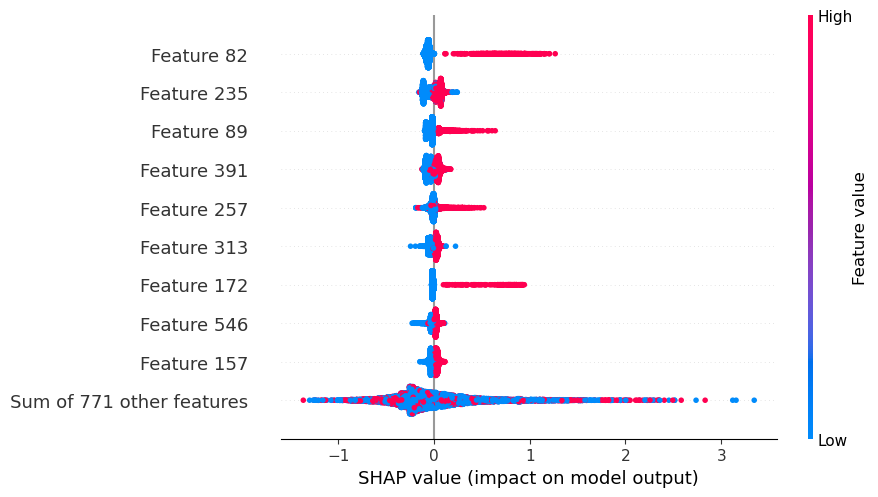

In [212]:
shap.plots.beeswarm(shap_values)

In [213]:
shap_values_ts = explainer(x_ts)

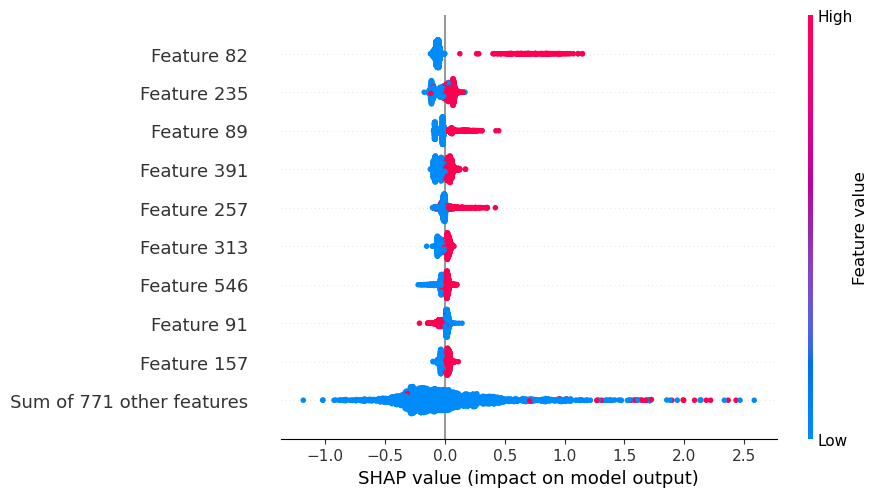

In [214]:
shap.plots.beeswarm(shap_values_ts)